In [3]:

# only run this once if required and margin list has changes from website!!! 
# just run everything else below this cell on regular basis

# import margin from westpac website
import tabula
import pandas as pd
myfile = 'https://www.westpac.com.au/content/dam/public/wbc/documents/pdf/pb/1999030/WOIL_Acceptable_Securities_List.pdf'

df2 = tabula.read_pdf(myfile,pages='all')
frames = [df2[0],df2[1],df2[2],df2[3]]
df2 = pd.concat(frames)
df2.drop(['Unnamed: 0','Unnamed: 1','APIR Code','Fund Name','APIR Code Fund Name'],axis=1) 
split1 = df2[['ASX Code','Security Name','LVR']]
split2 = df2[['ASX Code.1','Security Name.1','LVR.1']]
split2.columns=['ASX Code','Security Name','LVR']
df2 = pd.concat([split1,split2])
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['ASX Code'])
#df2.loc[:,'ASX Code']=df2['ASX Code'] + '.AX'


a = pd.read_csv('margin.csv')
df = pd.merge(a,df2,on='ASX Code',how='left')
df = df.drop(['LVR_x','Security Name_x'],axis=1)
df = df.rename(columns={'Security Name_y':'Security Name','LVR_y':'LVR'})
df = df[['ASX Code','Security Name','LVR','Industry','Valuation']]
#df = df.style.set_properties(**{'text-align': 'left'})

df.to_csv('marg.csv')

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
#import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly
pd.options.display.float_format = '{:,.2f}'.format


# myfunction to use MACD to give signal


# 1. look at mac
# 2. look at overall market 

def MAC(MACDiff,MACD,Trigger,Movement):
    if MACDiff >= 0.01:
        if MACD < 0 and MACD < Trigger:
            action = 'Buy - accumulate'
        elif MACD < 0 and MACD > Trigger and Movement > 0:
            action = 'Buy - positive trigger'
        elif MACD < 0 and MACD > Trigger and Movement < 0:
            action = 'Buy - weak trigger'
        elif MACD > 0 and MACD > Trigger:
            action = 'Buy - positive signal'
        else:
            action = 'MACD increases but no comment'
    elif MACDiff > -0.01 and MACDiff < 0.01:
        if Movement > 0:
            action = 'MACD flat with buy activity'
        elif Movement < 0:
            action = 'MACD flat with sell activity'
        else:
            action = 'Sideway'
    else:    # MACDIFF IS NEGATIVE
        if MACD > 0:
            action = 'Buy - but momentum declines'    
        elif MACD < 0 and MACD < Trigger:
            action = 'Sell'
        elif MACD < 0 and Movement > 0:                 
            action = 'Sell - a bit of buy support'       #technical bad but ppl still buy? must be good value
        else:
            action = 'MACD declines'
    return action



# my purchase price table
myInput = pd.DataFrame({'Code':['AGL.AX','WPL.AX','WBC.AX'],
                        'PurchasePrice': [13.535,19.98,21.35],
                        'Unit': [4447,1275,163],
                        'InPortfolio':['y','y','y']
                       })

# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)


# new code to pick up from csv instead with more details
mycsv = 'https://raw.githubusercontent.com/RonnyCh/mydsbook/master/margin.csv'
mystock = pd.read_csv(mycsv)
mystock = mystock['ASX Code']
#mystock = mystock.replace('^AORD.AX','^AORD')    # all ord does not come with .ax

# convert to string to make it better with dowloanding tracker
mystring = ''
mylist = []
for i in mystock:
    if i in ['^AORD','^DJI','^FTSE','CL=F','^AXJO','^IXIC','^HIS','^N225']:     # indexes no need to add .AX
        mystring = mystring + ' ' + i
        mylist.append(i)
    else:
        mystring = mystring + ' ' + i + '.AX'
        mylist.append(i+'.AX')

# download data 
data = yf.download(mystring, start=start, end=end, group_by="ticker")


# create columns for dataframe and the dataframe itself
mycol = ['Code','Close','Movement','Volume','ShortAvg','LongAvg','MACD','Trigger','Max','Min','2DAvg','VolDiff','P/Max']
mytbl = pd.DataFrame(columns=mycol)


# looping through the list to modify table
for i in mylist:
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]    # old code using datareader (not working well)
    #df = yf.download(i, start=start, end=end)[['Close','Volume']]      # old Yfinance code
    
    df = data[i][['Close','Volume']]     # new one using Yfinance
    df['Code'] = i
   #df.loc[:,'ShortAvg'] = df.Close.rolling(window=7).mean()
    df.loc[:,'ShortAvg'] = df.Close.ewm(span=5).mean()        
    df.loc[:,'LongAvg'] = df.Close.ewm(span=14).mean()
    df['MACD'] = df['ShortAvg'] - df['LongAvg']
    df['Trigger'] = df.MACD.rolling(window=4).mean()
    df['Movement'] = df['Close'].diff(1)
    df['2DAvg'] = df.Movement.rolling(window=2).sum()
    df['Max'] = df['Close'].max()
    df['Min'] = df['Close'].min()
    df['VolDiff'] = df['Volume'].diff(1)
    df['P/Max'] = df['Close']/df['Max']
    mytbl = mytbl.append(df)

mytbl = mytbl.reset_index()
mytbl = mytbl.rename(columns={'index':'Date'})


############## SQL TO MERGE WITH MY INPUT ##############
code = pd.merge(mytbl,myInput,on='Code',how='left')
code = code.rename(columns={'index':'Date'})


#remove null values
code['Unit'] = code['Unit'].fillna(0)
code['PurchasePrice'] = code['PurchasePrice'].fillna(0)
code['InPortfolio'] = code['InPortfolio'].fillna('n')

code['Profit'] = (code['Close'] - code['PurchasePrice']) * code['Unit']
#code['AvgPctg'] = (code['Wkly']-code['TwoWks'])/code['TwoWks'] * 100

#code['Diff'] = code['Wkly'] - code['TwoWks']
#code['DdownCnt']=code['Ddown'].rolling(window=14,min_periods=1).count()




# create another table to give signal
#mysignal = code
#mysignal['MACD_Diff'] = mysignal['MACD'].diff(1)
#mysignal['Advice']=mysignal.apply(lambda x:MAC(x['MACD_Diff'],x['MACD'],x['Trigger'],x['Movement']),axis=1)




code['MACD_Diff'] = code['MACD'].diff(1)
code['Advice']=code.apply(lambda x:MAC(x['MACD_Diff'],x['MACD'],x['Trigger'],x['2DAvg']),axis=1)


code.to_csv('YahooFinance.csv')


#code.head()






#code.to_csv('mysignal.csv')





[*********************100%***********************]  399 of 399 completed

1 Failed download:
- FXL.AX: No data found, symbol may be delisted


In [8]:
from IPython.display import display


print("Enter Your Date YYYY-MM-DD ")
mydate = input()
mydate = pd.to_datetime(mydate)

mycol = ['Date','Code','Close','MACD','Trigger','MACD_Diff','Movement','2DAvg','Min','Max','P/Max','Advice']
rec = code[mycol]

mylist = ['^AORD','^DJI','WPL.AX','AGL.AX','IAG.AX','TWE.AX','LNK.AX','CSL.AX','ALL.AX','ORG.AX']
b = rec[(rec['Date']==mydate) & (rec['Code'].isin(mylist))]

a = rec[(rec['Date']==mydate) & rec['Advice'].str.contains('trigger') & (rec['P/Max'] < 0.91)]
mystock = pd.read_csv(mycsv)
mystock = mystock.rename(columns={'ASX Code':'Code'})
mystock['Code']=mystock['Code'] + '.AX'
mycol = ['Date','Code','Industry','LVR','Close','MACD','Trigger','2DAvg','Max','P/Max','Advice']
mybuy = pd.merge(a,mystock,on='Code')
mybuy = mybuy[mycol]
mybuy = mybuy.sort_values(['LVR','P/Max'],ascending=False)

display (b)
display (mybuy)
#type(a)

Enter Your Date YYYY-MM-DD 
2021-02-03


,Date,Code,Close,MACD,Trigger,MACD_Diff,Movement,2DAvg,Min,Max,P/Max,Advice
623,2021-02-03,^DJI,nan,-149.38,-192.05,0.00,nan,nan,"25,706.09","31,188.38",nan,Sideway
1091,2021-02-03,^AORD,"7,090.90",12.29,-16.76,25.05,63.40,168.10,"5,973.50","7,111.40",1.00,Buy - positive signal
2807,2021-02-03,AGL.AX,11.85,-0.08,-0.16,0.08,0.28,0.40,11.45,17.59,0.67,Buy - positive trigger
3743,2021-02-03,ALL.AX,32.90,0.66,0.33,0.19,0.28,1.22,24.18,34.59,0.95,Buy - positive signal
16691,2021-02-03,CSL.AX,280.26,1.38,-0.03,1.25,5.93,2.20,266.90,318.58,0.88,Buy - positive signal
26363,2021-02-03,IAG.AX,4.97,-0.02,-0.03,0.02,0.10,0.11,4.38,5.83,0.85,Buy - positive trigger
31355,2021-02-03,LNK.AX,5.02,0.06,0.03,0.02,0.04,0.16,3.73,5.64,0.89,Buy - positive signal
38999,2021-02-03,ORG.AX,4.96,-0.05,-0.08,0.03,0.07,0.11,4.00,6.02,0.82,Buy - positive trigger
53351,2021-02-03,TWE.AX,10.43,0.36,0.29,0.06,0.17,0.57,7.96,12.85,0.81,Buy - positive signal
60371,2021-02-03,WPL.AX,25.28,-0.26,-0.35,0.10,0.20,0.73,16.80,27.40,0.92,Buy - positive trigger


,Date,Code,Industry,LVR,Close,MACD,Trigger,2DAvg,Max,P/Max,Advice
38,2021-02-03,RIO.AX,Materials,75%,113.76,-2.06,-2.62,2.49,125.66,0.91,Buy - positive trigger
17,2021-02-03,IAG.AX,Insurance,75%,4.97,-0.02,-0.03,0.11,5.83,0.85,Buy - positive trigger
7,2021-02-03,AZJ.AX,Transportation,75%,3.76,-0.05,-0.06,0.03,4.98,0.76,Buy - positive trigger
2,2021-02-03,AGL.AX,Utilities,75%,11.85,-0.08,-0.16,0.40,17.59,0.67,Buy - positive trigger
25,2021-02-03,MGR.AX,Real Estate,70%,2.50,-0.03,-0.05,0.08,2.76,0.91,Buy - positive trigger
44,2021-02-03,SYD.AX,Transportation,70%,5.97,-0.07,-0.13,0.25,6.91,0.86,Buy - positive trigger
3,2021-02-03,ALD.AX,Energy,70%,26.87,-0.96,-1.10,0.57,31.14,0.86,Buy - positive trigger
21,2021-02-03,LLC.AX,Real Estate,70%,12.35,-0.15,-0.23,0.08,14.89,0.83,Buy - positive trigger
30,2021-02-03,ORG.AX,Energy,70%,4.96,-0.05,-0.08,0.11,6.02,0.82,Buy - positive trigger
29,2021-02-03,NCM.AX,Materials,70%,25.41,-0.43,-0.49,-0.24,36.80,0.69,Buy - weak trigger


Enter the code you want to check
ALL.AX


Text(0.5, 0, 'Long vs Short Avg')

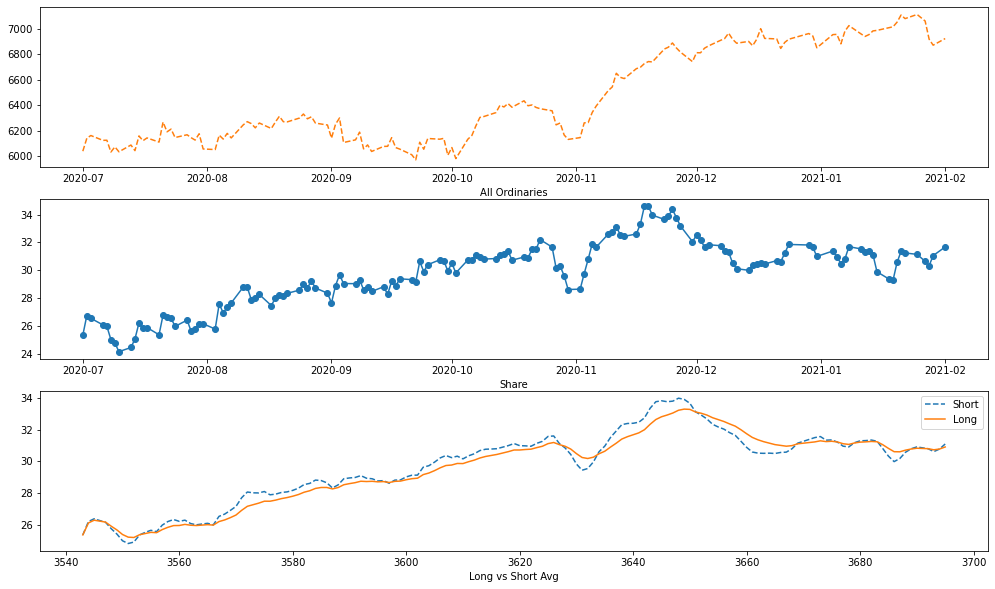

In [49]:
import matplotlib.pyplot as plt

print("Enter the code you want to check")
x = input()

plt.subplots(figsize=(17,10))

code = mytbl[mytbl['Code']==x]
code.dropna(subset=['Close'],inplace=True)
index = mytbl[mytbl['Code']=='^AORD']
index.dropna(subset=['Close'],inplace=True)


plt.subplot(311)
a = index['Date']
b = index['Close']
plt.plot(a,b,color='tab:orange',linestyle='--')
plt.xlabel('All Ordinaries')

plt.subplot(312)
a = code['Date']
b = code['Close']
plt.plot(a,b,color='tab:blue', marker='o')
plt.xlabel('Share')

plt.subplot(313)
short = code['ShortAvg']
long = code['LongAvg']

plt.plot(short, label ='Short',linestyle='--')
plt.plot(long, label = 'Long')
plt.legend()
plt.xlabel('Long vs Short Avg')

In [9]:
import numpy as np


#mydate = datetime.date.today().strftime("%Y-%m-%d")
#mydate = datetime.date.today() + datetime.timedelta(days=0) #change time delta accordingly, default = 0 or now
# the format of this input : Start, End, Code, Type, Unit, Price
print("Enter Your Date YYYY-MM-DD ")
mydate = input()
mydate = pd.to_datetime(mydate)
# type --> b = buy , s = sell , w = watchlist
myval = [
    # Bought Date, Sold Date, Code, Type, Unit, Price, Margin
   
    
    ['2020-10-15',mydate,'AGL.AX','Long Term',4447,13.55],
    ['2020-12-15',mydate,'AGL.AX','Short Term',775,12.885],
    ['2020-8-27',mydate,'IAG.AX','Long Term',6060,5.08],
    ['2020-12-04',mydate,'CSL.AX','Long Term',33,294.19], 
    ['2020-12-11',mydate,'CSL.AX','Long Term',68,292.025], 
    ['2020-12-21',mydate,'CSL.AX','Long Term',34,287.511], 
    ['2021-1-12' ,mydate,'CSL.AX','Short Term',54,274.11],     
    ['2020-8-26',mydate,'WPL.AX','Long Term',1275,19.98],
    ['2020-11-25',mydate,'WPL.AX','Long Term',427,23.36],
    ['2020-12-2',mydate,'WPL.AX','Long Term',224,22.24],
    ['2020-12-21',mydate,'TWE.AX','Long Term',607,9.38],
    ['2021-1-4',mydate,'LNK.AX','Long Term',1236,4.78]
    
     ]

# create two tables (manual input vs table for ALLORD)
myinput = pd.DataFrame(myval,columns=['Date','Date_to','Code','Type','Unit','Price'])
myinput['Date']= myinput['Date'].astype('datetime64[ns]')                  # change from objec to the date type
allord = code[code['Code']=='^AORD'][['Date','Close']]



# merge tables to create a consolidated with share vs ordinary

benchmark = pd.merge(myinput,allord,on='Date',how='inner')
#benchmark['']

# loop all the description and create dataframe 
for i in range(len(benchmark['Date'])):
        StartDate = benchmark.loc[i,'Date']
        EndDate = benchmark.loc[i,'Date_to']
        Code = benchmark.loc[i,'Code']
        Unit = benchmark.loc[i,'Unit']
        Price = benchmark.loc[i,'Price']
        Index = benchmark.loc[i,'Close']
        Type = benchmark.loc[i,'Type']
        
        dateseries = pd.date_range(StartDate,EndDate)
        mypurchasedate = np.repeat(StartDate,len(dateseries))
        myunit = np.repeat(Unit,len(dateseries))
        myprice = np.repeat(Price,len(dateseries))
        mycode = Code
        
        if i ==0 : # create the main dataframe the first time
            df1 = pd.DataFrame ({'Date':dateseries, 'Bought_Date':StartDate,'Type':Type,'Code':mycode,'Unit':myunit,'Price':myprice,'Index':Index})
        else:      # create tmp and append to main dataframe
            tmp = pd.DataFrame ({'Date':dateseries, 'Bought_Date':StartDate,'Type':Type,'Code':mycode,'Unit':myunit,'Price':myprice,'Index':Index})
            df1 = df1.append(tmp)
            

            
# create final profit table         

#mydate = datetime.date.today() + datetime.timedelta(days=-1)    #change time delta accordingly, default = 0 or now
mydate = mydate.strftime("%Y-%m-%d")
myprofit =  pd.merge(df1,code,on=['Date','Code'],how='inner')[['Date','Bought_Date','Type','Code','Unit_x','Price','Close','Index']]
myprofit =  pd.merge(myprofit,allord,on='Date',how='inner')
myprofit = myprofit.rename(columns={'Unit_x':'Unit','Close_x':'Close','Close_y':'Index_Close'})
myprofit = myprofit.sort_values(by=['Type'])
myprofit['Index_Unit'] = (myprofit['Unit'] * myprofit['Price'])/myprofit['Index']
myprofit['MyProfit'] = (myprofit['Close'] - myprofit['Price']) * myprofit['Unit']
myprofit['Benchmark'] = (myprofit['Index_Close'] - myprofit['Index']) * myprofit['Index_Unit']
#myprofit['Profit_Impact'] = myprofit['MyProfit'] - myprofit['Benchmark']
myprofit['Profit%'] = (myprofit['Close']-myprofit['Price'])/myprofit['Price']
myprofit['Index%'] = (myprofit['Index_Close']-myprofit['Index'])/myprofit['Index_Close']
myprofit['Diff%'] = myprofit['Profit%'] - myprofit['Index%']  
myprofit['TotCost'] = myprofit['Unit'] * myprofit['Price']  
#myprofit.style.format({'Profit%':"{:.2%}"})




mycolumns = ['Type','Code','Date','Bought_Date','Unit','Price','TotCost','Close','MyProfit','Benchmark','Profit%','Index%','Diff%']
myprofit = myprofit[mycolumns]

myprofit[myprofit['Date'] == mydate]
mydf = myprofit[myprofit['Date']==mydate].sort_values(by=['Type','Code','Bought_Date'])
#myprofit.style.format({'Profit%':"{:.2%}",'Index%':"{:.2%}"})
#myprofit[myprofit['Date'] == mydate]

final = mydf.groupby('Code').sum()[['Unit','TotCost']]
final['AvgCost'] = final['TotCost']/final['Unit']

print ('########## Your Average Costs ############')
print (final)


print ('########### Benchmark against all ordinaries ##############')

mylvr = mystock[['Code','LVR']]

mydf = pd.merge(mydf,mylvr,on='Code',how='left')
#mydf['MarginUsed'] = mydf['LVR'] * mydf['TotCost']
mydf


Enter Your Date YYYY-MM-DD 
2021-02-03
########## Your Average Costs ############
        Unit   TotCost  AvgCost
Code                           
AGL.AX  5222 70,242.73    13.45
CSL.AX   189 54,143.28   286.47
IAG.AX  6060 30,784.80     5.08
LNK.AX  1236  5,908.08     4.78
TWE.AX   607  5,693.66     9.38
WPL.AX  1926 40,430.98    20.99
########### Benchmark against all ordinaries ##############


,Type,Code,Date,Bought_Date,Unit,Price,TotCost,Close,MyProfit,Benchmark,Profit%,Index%,Diff%,LVR
0,Long Term,AGL.AX,2021-02-03,2020-10-15,4447,13.55,"60,256.85",11.85,"-7,559.90","6,357.11",-0.13,0.10,-0.22,75%
1,Long Term,CSL.AX,2021-02-03,2020-12-04,33,294.19,"9,708.27",280.26,-459.69,319.02,-0.05,0.03,-0.08,75%
2,Long Term,CSL.AX,2021-02-03,2020-12-11,68,292.02,"19,857.70",280.26,-800.02,589.70,-0.04,0.03,-0.07,75%
3,Long Term,CSL.AX,2021-02-03,2020-12-21,34,287.51,"9,775.37",280.26,-246.53,241.42,-0.03,0.02,-0.05,75%
4,Long Term,IAG.AX,2021-02-03,2020-08-27,6060,5.08,"30,784.80",4.97,-666.60,"3,806.51",-0.02,0.11,-0.13,75%
5,Long Term,LNK.AX,2021-02-03,2021-01-04,1236,4.78,"5,908.08",5.02,296.64,116.57,0.05,0.02,0.03,60%
6,Long Term,TWE.AX,2021-02-03,2020-12-21,607,9.38,"5,693.66",10.43,637.35,140.61,0.11,0.02,0.09,65%
7,Long Term,WPL.AX,2021-02-03,2020-08-26,1275,19.98,"25,474.50",25.28,"6,757.50","3,223.11",0.27,0.11,0.15,75%
8,Long Term,WPL.AX,2021-02-03,2020-11-25,427,23.36,"9,974.72",25.28,819.84,293.53,0.08,0.03,0.05,75%
9,Long Term,WPL.AX,2021-02-03,2020-12-02,224,22.24,"4,981.76",25.28,680.96,204.50,0.14,0.04,0.10,75%


In [10]:
print ('### Overall Profit ###')
overall = mydf.groupby('Type').sum()[['Unit','MyProfit']]

print (overall)

mydf.groupby('Code').sum()[['Unit','MyProfit']]

### Overall Profit ###
             Unit  MyProfit
Type                       
Long Term   14411   -540.45
Short Term    829   -470.02


,Unit,MyProfit
Code,,
AGL.AX,5222,"-8,362.02"
CSL.AX,189,"-1,174.14"
IAG.AX,6060,-666.60
LNK.AX,1236,296.64
TWE.AX,607,637.35
WPL.AX,1926,"8,258.30"
